In [2]:
from __future__ import unicode_literals, print_function, division
import time
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")
import time
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, RandomSampler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
device
data_path = "data/"
import session_info
plt.ion()

cuda


In [119]:

#################LOAD DATA############################
dataset = pd.read_csv(data_path+"giga_dataset.csv")

In [3]:
####Split the dataset into low, muffled, normal and high
def split_dataset():
    list_utterance_type = ["low", "muffled", "normal", "high"]
    for type in list_utterance_type:
        data = dataset[dataset["script_id"].str.contains(type)]
        data.to_csv(data_path+type+"_dataset.csv", index=False)

In [3]:
SOS_token = 0
EOS_token = 0
MAX_LENGTH = 500
class Mydataset(Dataset):
    def __init__(self, inputs, targets):
        self.targets = targets
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

def get_au_dictionary(dataframe):
    dic = {}
    groups = dataframe.groupby('script_id').groups #group by duplicates script_id and return a dictionary of indexes where the key is the script_id and the value is a list of indexes
    for key, val in groups.items():
        dt_indexed = dataframe.iloc[val]  #iloc is for integer indexing
        au = dt_indexed.loc[:, dt_indexed.columns.str.endswith("_r")] #loc is for label indexing
        dic[key] = au
    return dic

def prepare_data(data, only_bs=True):
    ##pairs are same script name over n number of lines
    ##while name is not different, take the first 17 au columns, and the last 61 columns (ARKIT results) to form a pair
    ##return a list of pairs of dataframe
    pairs = []
    groups = data.groupby('script_id').groups #group by duplicates script_id and return a dictionary of indexes where the key is the script_id and the value is a list of indexes
    for key, val in groups.items():
        dt_indexed = data.iloc[val]  #iloc is for integer indexing
        au = dt_indexed.loc[:, dt_indexed.columns.str.endswith("_r")] #loc is for label indexing
        bs = dt_indexed.iloc[:, -61:] #selects the last 61 columns corresponding to blendshapes + eyes rotation and head rotation in 3 axes (+ 9 variables) )
        if only_bs:
            bs = bs.iloc[:, :-9] #Drop the 9 columns not related to blendshapes (eyes + head rotation)
        length = au.shape[0]
        pairs.append((au, bs, length))
    return pairs

def sort_pairs(pairs):
    return [(inp, tgt, l) for inp, tgt, l in pairs if l < MAX_LENGTH ]
    

def my_collate_fn(batch):
    #sort batch in descending order
    #Batch is list of tuples
    inp = [x[0] for x in batch]
    tgt = [x[1] for x in batch]
    sorted_inp = sorted(inp, key=lambda x: x.shape[0], reverse=True)
    sorted_tgt = sorted(tgt, key=lambda x: x.shape[0], reverse=True)
    #get a list of each batch length
    lengths_of_batches = torch.LongTensor([x.shape[0] for x in sorted_inp])
    input_tensors = [torch.FloatTensor(inp).to(device) for inp in sorted_inp]
    target_tensors = [torch.FloatTensor(tgt).to(device) for tgt in sorted_tgt]
    padded_input = torch.nn.utils.rnn.pad_sequence(input_tensors)
    padded_target = torch.nn.utils.rnn.pad_sequence(target_tensors)
    return padded_input, padded_target, lengths_of_batches

#padded sequence
def get_dataloader(batch_size, data, train_data_percentage=0.7, test_data_percentage=0.2,short_sentences=False, only_bs=True):
    if train_data_percentage + test_data_percentage >= 1:
        print("train + test data_percentage must be lower than 1. You need room for the valid dataset")
        return
    pairs = prepare_data(data, only_bs=only_bs)
    if short_sentences:
        pairs = sort_pairs(pairs)
    inputs = [x[0].to_numpy() for x in pairs]
    targets = [x[1].to_numpy() for x in pairs]
    data = Mydataset(inputs, targets)
    generator = torch.Generator().manual_seed(42) #for reproductability
    train_size = int(train_data_percentage * len(data))
    test_size = int(test_data_percentage*len(data))
    val_size = int(len(data) - train_size - test_size)
    train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, val_size, test_size], generator=generator)
    
    train_sampler = RandomSampler(train_dataset)
    test_sampler = RandomSampler(test_dataset)
    valid_sampler = RandomSampler(validation_dataset)

    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size, collate_fn=my_collate_fn)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size, collate_fn=my_collate_fn)
    validation_dataloader = DataLoader(validation_dataset, sampler=valid_sampler, batch_size=batch_size, collate_fn=my_collate_fn)
    return [train_dataloader, validation_dataloader, test_dataloader]


In [4]:
torch.autograd.set_detect_anomaly(True)

#From StackOverflow : https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss, model, criterion, voice_type):
        if validation_loss < self.min_validation_loss:
            torch.save(model.state_dict(), f"pytorch models/{voice_type}/{model.__class__.__name__}_{criterion.__class__.__name__}_{voice_type}.pth")
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


class GRUNet(nn.Module):
    def __init__(self, input_size=17, hidden_size=128, output_size=61, dropout_p=0.1):
        super(GRUNet, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(input_size, self.hidden_size)
        self.linear = nn.Linear(hidden_size, output_size, device=device)
        self.relu = nn.ReLU()

    def forward(self, input_tensor):
        output, _ = self.gru(input_tensor)
        output = self.linear(output)
        output = self.dropout(output)
        output = self.relu(output)
        return output

    def train_epoch(self, dataloader, optimizer, criterion):
        total_loss = 0
        self.train()
        for batch in dataloader:
            input_tensor, target_tensor, l = batch
            optimizer.zero_grad()
            outputs = self.forward(input_tensor)
            loss = self.loss_comp(outputs, target_tensor, criterion, l)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)
    
    def loss_comp(self, out, target, criterion, l=None):
        return criterion(out.view(-1), target.view(-1))
    

    def evaluate_epoch(self, valid_dataloader, criterion):
        loss = 0
        self.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                inp, tgt, l = batch
                out = self.forward(inp)
                loss += self.loss_comp(out, tgt, criterion).item()
        return loss / len(valid_dataloader)
    
    def train_(self, train_dataloader, valid_dataloader, n_epochs, criterion, optimizer, voice_type):
        train_loss = []
        valid_loss = []
        last_epoch = 0
        best_loss = np.inf
        early_stopper = EarlyStopper(patience=10)
        for epoch in range(1, n_epochs + 1):
            tloss = self.train_epoch(train_dataloader, optimizer, criterion)
            vloss = self.evaluate_epoch(valid_dataloader, criterion)
            if vloss < best_loss:
                best_loss = vloss
            train_loss.append(tloss)
            valid_loss.append(vloss)
            last_epoch = epoch
            if early_stopper.early_stop(vloss, self, criterion, voice_type=voice_type):
                break
            print(f"epoch: {epoch}\n   train loss: {tloss}\t valid loss: {vloss}")
        print(f"best vloss: {best_loss}")
        plt.plot(train_loss, label="train loss")    
        plt.plot(valid_loss, label="valid loss")
        plt.legend(loc="upper right")
        plt.xlabel(f"epochs: ({last_epoch})")
        plt.ylabel("loss amplitude")
        plt.title(f"train {criterion.__class__.__name__} | {self.__class__.__name__}")

class GRUNetNeg(GRUNet):
    def __init__(self, input_size=17, hidden_size=128, output_size=61, dropout_p=0.1):
        super().__init__(input_size, hidden_size, output_size, dropout_p)

    def forward(self, input_tensor):
        output, _ = self.gru(input_tensor)
        output = self.linear(output)
        output = self.dropout(output)
        return output

    def loss_comp(self, out, target, criterion, l=None):
            return criterion(out.view(-1), target.view(-1)) + torch.mean(NegRELU(out.view(-1)))

class GRUNetPack(GRUNet):
    def __init__(self, input_size=17, hidden_size=128, output_size=61, dropout_p=0.1):
        super().__init__(input_size, hidden_size, output_size, dropout_p)

    def forward(self, input_tensor):
        gru_output, _ = self.gru(input_tensor)
        pad_output, _ = torch.nn.utils.rnn.pad_packed_sequence(gru_output)
        linear_out = self.linear(pad_output)
        output = self.dropout(linear_out)
        output = self.relu(output)
        return output
    

    def loss_comp(self, output, target, criterion, l):
        loss = 0
        pred_list = torch.nn.utils.rnn.unpad_sequence(output.clone(), l)
        target_list = torch.nn.utils.rnn.unpad_sequence(target, l)
        for pred, tgt in zip(pred_list, target_list):
            loss += criterion(pred.view(-1), tgt.view(-1))
        return loss

    def train_epoch(self, dataloader, optimizer, criterion):
        total_loss = 0
        self.train()
        for batch in dataloader:
            input_tensor, target_tensor, sequence_lengths = batch
            loss = 0
            input_gru = torch.nn.utils.rnn.pack_padded_sequence(input=input_tensor, lengths=sequence_lengths)
            optimizer.zero_grad()
            outputs = self.forward(input_gru)
            loss = self.loss_comp(outputs, target_tensor, criterion, sequence_lengths)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def evaluate_epoch(self, valid_dataloader, criterion):
        loss = 0
        self.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                inp, tgt, l = batch
                
                input_gru = torch.nn.utils.rnn.pack_padded_sequence(input=inp, lengths=l)
                out = self.forward(input_gru)
                loss += self.loss_comp(out, tgt, criterion, l).item()
        return loss / len(valid_dataloader)

class GRUNetSeq(GRUNetPack):
    def __init__(self, input_size=17, hidden_size=128, output_size=61, dropout_p=0.1):
        super().__init__(input_size, hidden_size, output_size, dropout_p=dropout_p)
        self.encoder = nn.GRU(input_size, hidden_size)
        self.decoder = nn.GRU(input_size+hidden_size, hidden_size) #concat input and context vector
        self.linear = nn.Linear(input_size + hidden_size*2, output_size) #concat input, hidden and context vectors
        self.tgr_len = 0
        self.batch_size = 0

    def _init(self, input_pack_tensor):
        #input = [sequence_length, batch_size, input_size]
        #target = [sequence_length, batch_size, output_size]
        input_pad, _ =  torch.nn.utils.rnn.pad_packed_sequence(input_pack_tensor)
        self.batch_size = input_pad.shape[1] 
        self.trg_len = input_pad.shape[0]
        enc_outputs, enc_hid = self.encoder(input_pack_tensor)
        return input_pad, enc_outputs, enc_hid

    def forward(self, input_pack_tensor):
        input_pad, enc_outputs, enc_hid = self._init(input_pack_tensor)
        hidden = torch.zeros(1, self.batch_size, self.hidden_size).to(device) #hidden = [1, batch_size, hidden_size]
        outputs = torch.zeros(self.trg_len, self.batch_size, self.output_size).to(device)

        for t in range(0, self.trg_len):
            inp = input_pad[t] #inp [4, input_size]
            inp = inp.unsqueeze(0) #inp [1, 4, input_size], gru accepts 3D batched tensors, this adds a new dimension at position 0
            input_context = torch.cat((inp, enc_hid), dim = 2) #input_contex = [1, 4, input_size+hidden_size]
            output, hidden = self.forward_step(input_context, hidden, enc_hid, inp)
            #output = [batch_size, output_size]
            outputs[t] = output
        return outputs # outputs = [batch_size, sequence lengths, output size]

    def forward_step(self, input_context, hidden, enc_hid, inp):
        output, hidden = self.decoder(input_context, hidden)
        #hidden = [1, 4, hidden_size]
        fc_input = torch.cat((inp.squeeze(0), hidden.squeeze(0), enc_hid.squeeze(0)), dim=1)
        output = self.linear(fc_input)
        return output, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, hidden, enc_output):
        hidden = hidden.unsqueeze(1).repeat(1, enc_output.shape[0], 1)
        # hidden = [seq_len, batch_size, hidden]
        enc_output = enc_output.permute(1, 0, 2)
        #encoder output = [seq_len, batch_size, hidden]
        energy = torch.tanh(self.Wa(hidden) + self.Ua(enc_output))  # Calculate energy for each sequence element
        scores = self.Va(energy).squeeze(2)  # Linear transformation and squeeze
        
        weights = F.softmax(scores, dim=1)  # Apply softmax to get attention weights
        context = torch.bmm(weights.unsqueeze(1), enc_output).squeeze(1)  # Calculate context vector

        return context, weights

class GRUNetAtt(GRUNetSeq):
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.1): #17
        super().__init__(input_size, hidden_size, output_size, dropout_p)
        self.attention = BahdanauAttention(hidden_size)
        self.decoder = nn.GRU(input_size+hidden_size, hidden_size)
        self.linear = nn.Linear(input_size+hidden_size*2, output_size)

    def forward(self, input_pack_tensor):
        input_pad, enc_outputs, enc_hid = self._init(input_pack_tensor)
        hidden = enc_hid #hidden = encoder hidden
        outputs = torch.zeros(self.trg_len, self.batch_size, self.output_size).to(device)
        enc_outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(enc_outputs, batch_first=False) #enc_outputs = [seq_len, batch_size, hidden_size]

        for t in range(0, self.trg_len):
            inp = input_pad[t] #inp [4, input_size]
            inp = inp.unsqueeze(0) #inp [1, 4, input_size]
            output, hidden = self.forward_step(enc_outputs, hidden, inp)
            #output = [batch_size, output_size]
            outputs[t] = output
        return outputs # outputs = [batch_size, sequence lengths, output size]

    def forward_step(self, enc_outputs, hidden, inp):
        context, _ = self.attention(hidden.squeeze(0), enc_outputs)
        context = context.unsqueeze(0) #context = [1, batch_size, hid]
        input_gru = torch.cat((inp, context), dim=2) #input gru = [1, batch_size, input_size + hidden_size]
        output, hidden = self.decoder(input_gru, hidden) #output = hidden = [1, batch_size, hidden_size]
        fc_input = torch.cat((output.squeeze(0), context.squeeze(0), inp.squeeze(0)), dim=1) #fc_input = [1, batch_size, input_size+hidden*3]
        output = self.linear(fc_input) #output = [1, batch_size, output_size]

        return output, hidden

class GRUNetSig(GRUNet):
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.1):
        super().__init__(input_size, hidden_size, output_size, dropout_p)
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(input_size, self.hidden_size)
        self.linear = nn.Linear(hidden_size, output_size, device=device)
        self.linear2 = nn.Linear(input_size, output_size, device=device)
        self.sig = nn.Sigmoid()
        self.bce = nn.BCELoss()

    def forward(self, input_packed):
        gru_output, _ = self.gru(input_packed)
        pad_output, _ = torch.nn.utils.rnn.pad_packed_sequence(gru_output)
        input2, _ = torch.nn.utils.rnn.pad_packed_sequence(input_packed)
        linear_out = self.linear(pad_output)
        activation_probability = self.linear2(input2)
        activation_probability = self.sig(activation_probability)
        return linear_out, activation_probability

    def loss_comp(self, output, target, prob, criterion, l):
        loss = 0
        bce_loss = 0
        out_list = torch.nn.utils.rnn.unpad_sequence(output.clone(), l)
        target_list = torch.nn.utils.rnn.unpad_sequence(target.clone(), l)
        prob_list = torch.nn.utils.rnn.unpad_sequence(prob.clone(), l)
        for p, t, prob in zip(out_list, target_list, prob_list):
            tr = nn.Threshold(0.5, 0)
            prob_threshold = (tr(prob) != 0).float()
            new_p = prob_threshold*p
            loss += criterion(new_p.view(-1), t.view(-1))
            bce_loss += my_bce_loss(prob, t, self.bce)
        return (loss)+(bce_loss*0.1)

    def train_epoch(self, dataloader, optimizer, criterion):
        total_loss=0
        self.train()
        for batch in dataloader:
            optimizer.zero_grad()
            input_tensor, target_tensor, lengths = batch
            input_gru = torch.nn.utils.rnn.pack_padded_sequence(input=input_tensor, lengths=lengths)
            out, out_pred = self.forward(input_gru)
            loss = self.loss_comp(out, target_tensor, out_pred, criterion, lengths)
            loss.backward()
            #scheduler.step()
            optimizer.step()
            total_loss+=loss.item()
        return total_loss / len(dataloader)   

    def evaluate_epoch(self, valid_dataloader, criterion):
        loss = 0
        self.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                inp, tgt, l = batch
                input_gru = torch.nn.utils.rnn.pack_padded_sequence(input=inp, lengths=l)
                out, prob = self.forward(input_gru)
                loss += self.loss_comp(out, tgt, prob, criterion, l).item()
        return loss / len(valid_dataloader)   

class FCNet(GRUNet):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__(input_size, hidden_size, output_size)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_tensor):
        out = self.linear1(input_tensor)
        out = self.linear2(out)
        out = self.out(out)
        out = self.relu(out)
        return out
    
    def loss_comp(self, output, target, criterion, l):
        loss = 0
        pred_list = torch.nn.utils.rnn.unpad_sequence(output.clone(), l)
        target_list = torch.nn.utils.rnn.unpad_sequence(target, l)
        for pred, tgt in zip(pred_list, target_list):
            loss += criterion(pred.view(-1), tgt.view(-1))
        return loss
    
    def evaluate_epoch(self, valid_dataloader, criterion):
        loss = 0
        self.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                inp, tgt, l = batch
                out = self.forward(inp)
                loss += self.loss_comp(out, tgt, criterion, l).item()
        return loss / len(valid_dataloader)

def NegRELU(tensor): ##Custom loss function to penalize negative values
    relu = nn.ReLU()
    return relu(torch.neg(tensor))

class RMSELoss(nn.Module):
    def __init__(self, reduction="mean"):
        super(RMSELoss, self).__init__()
        self.reduction = reduction

    def forward(self, inp, target):
        if self.reduction == "mean":
            mse = torch.mean((inp - target) ** 2)
            rmse = torch.sqrt(mse + 1e-7)
            return rmse
        elif self.reduction == "none":
            mse = (inp - target) ** 2
            rmse = torch.sqrt(mse+1e-7)
        elif self.reduction == "sum":
            mse = torch.sum((inp - target) ** 2)
            rmse = torch.sqrt(mse + 1e-7)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)

def my_bce_loss(x, y, bce): ###Custom BCE
    activated = (y != 0).float().clamp(min=1e-10)
    unactivated = (y == 0).float().clamp(min=1e-10)
    Tr = nn.Threshold(0.5, 1e-10)
    act_x = Tr(x)
    unact_x = (x - act_x).clamp(min=1e-10)
    term1 = (torch.log(act_x)*activated).clamp(1e-10)
    term2 =  (torch.log(unact_x)*unactivated).clamp(1e-10)
    column_losses = -1.0 * (torch.mean(term1, dim=1) + torch.mean(term2, dim=1)) # Calculate mean along the row dimension
    #loss = bce(x, activated)
    return column_losses.mean()

In [5]:
hidden_size = 128
batch_size = 4
input_size = 17 # action units
output_size = 52 # blendshapes
lr=0.001

In [120]:
####Load data
train_dataloader, valid_dataloader, test_dataloader = get_dataloader(batch_size=batch_size, data=dataset, short_sentences=False, only_bs=True)
print(f"train size: {len(train_dataloader.dataset)}, valid size: {len(valid_dataloader.dataset)}, test size: {len(test_dataloader.dataset)}")

train size: 2625, valid size: 375, test size: 750


In [6]:
%matplotlib inline
import sys

torch.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize)

seqModel = GRUNetSig(input_size, hidden_size, 52).to(device)
seqModel.apply(init_weights)
optimizer = optim.Adam(seqModel.parameters(), lr=lr)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
criterion = nn.MSELoss(reduction="mean")
start_time = time.time()
print(len(train_dataloader.dataset), len(test_dataloader.dataset))
seqModel.train_(train_dataloader, valid_dataloader, n_epochs=100, criterion=criterion, optimizer=optimizer, voice_type="low")
print("--- %s seconds ---" % (time.time() - start_time))

NameError: name 'train_dataloader' is not defined

In [7]:
# list_of_bs = [[] for i in range(52)]
# for i, l in enumerate(loss_bs):
#     for j, val in enumerate(l):
#         list_of_bs[j].append(val.item())

def save_loss_for_each_bs(loss_bs):
    columns = dataset.columns[-61:]
    columns = columns[:-9] #remove 9 last columns
    loss_detach = [[val.item() for val in l] for l in loss_bs]
    np_list = np.array(loss_detach)
    for i, l in enumerate(np_list.transpose()):
        fig, ax = plt.subplots()
        ax.plot(np.arange(0, len(l)), l)
        ax.title.set_text(columns[i])
        #plt.savefig("bs_loss/" + columns[i] + "loss.png")

In [8]:
%matplotlib inline
from torchmetrics.regression import R2Score
def evaluate(criterion, model, test_data, loss_by_bs=False, use_pack=True, with_prob=False):
        model.eval()
        plot_loss = []
        predictions = []
        activation_precision = []
        activation_recall = []
        loss_arr = []
        if loss_by_bs:
            criterion = criterion.__class__(reduction="none")
        with torch.no_grad():
            prob=None
            for inp, tgt, sequence_lengths in test_data:
                loss_by_batch = []
                if use_pack:
                    inp = torch.nn.utils.rnn.pack_padded_sequence(input=inp, lengths=sequence_lengths)
                if with_prob:
                    output, prob = model(inp)
                else:
                    output = model(inp)
                compute_loss_function(criterion, output, tgt, sequence_lengths, activation_precision, activation_recall, plot_loss, loss_by_batch, loss_arr, prob, loss_by_bs)

                #Predictions is a list of tuples, output has the shape L*Batch*blendshape counts, sequence lengths will be useful to cut script values
                predictions.append((inp, output, sequence_lengths))
        print(f'mean  {criterion.__class__.__name__}: {np.mean(plot_loss)}')
        print(f"mean activation precision: {np.mean(activation_precision)}")
        print(f"mean activation recall: {np.mean(activation_recall)}")
        plt.plot(plot_loss)
        plt.xlabel(f"scripts ({len(plot_loss)})")
        plt.ylabel("loss amplitude")
        plt.title(f"test {criterion.__class__.__name__} | {model.__class__.__name__}")
        return predictions, loss_arr


def loss_unpad(criterion, pred_list, target_list, plot_loss, loss_by_batch, activation_precision, activation_recall, loss_arr, loss_by_bs):
    for p, t in zip(pred_list, target_list):
        act_p, act_r = (evaluate_true_positive(p, t))
        activation_precision.append(act_p)
        activation_recall.append(act_r)
        if loss_by_bs:
            val_loss = torch.mean(criterion(p, t), dim=0)
            loss_arr.append(val_loss)
            val_loss = val_loss.mean()
        else: 
            val_loss = criterion(p.view(-1), t.view(-1))
        plot_loss.append(val_loss.item())
        loss_by_batch.append(val_loss.item())

def loss_with_prob(criterion, pred_list, target_list, prob_list, plot_loss, loss_by_batch, activation_precision, activation_recall, loss_arr, loss_by_bs):
    for p, t, prob in zip(pred_list, target_list, prob_list):
        tr = nn.Threshold(0.5, 0)
        prob_threshold = (tr(prob) > 1e-5).float()
        new_pred = prob_threshold*p
        act_p, act_r = evaluate_true_positive(new_pred, t)
        activation_precision.append(act_p)
        activation_recall.append(act_r)
        if loss_by_bs:
            val_loss = torch.mean(criterion(p, t), dim=0)
            loss_arr.append(val_loss)
            val_loss = val_loss.mean()
        else:
            val_loss = criterion(p.view(-1), t.view(-1))
        plot_loss.append(val_loss.item())
        loss_by_batch.append(val_loss.item())

def compute_loss_bs_wise(criterion, output, tgt, plot_loss, activation_precision, activation_recall):
    ###Permute dimension and flatten the tensors to have a shape [52, sequence_length*batch_size], allow to compute loss for each 52 blendshapes
    array = criterion(torch.flatten(output.permute(2, 0, 1), start_dim=1), torch.flatten(tgt.permute(2, 0, 1), start_dim=1))
    loss_arr = torch.mean(array, dim=1)
    loss = torch.sum(loss_arr)
    plot_loss.append(loss.item())
    act_p, act_r = (evaluate_true_positive(output, tgt))
    activation_precision.append(act_p)
    activation_recall.append(act_r)

def compute_loss_function(criterion, output, tgt, seq_length, activation_precision, activation_recall, plot_loss, loss_by_batch, loss_arr, prob, loss_by_bs):
    pred_list = torch.nn.utils.rnn.unpad_sequence(output.clone(), seq_length)
    target_list = torch.nn.utils.rnn.unpad_sequence(tgt, seq_length)
    if prob!=None:
        prob_list = torch.nn.utils.rnn.unpad_sequence(prob, seq_length)
        loss_with_prob(criterion, pred_list, target_list, prob_list, plot_loss, loss_by_batch, activation_precision, activation_recall, loss_arr, loss_by_bs)
    else:
        loss_unpad(criterion, pred_list, target_list, plot_loss, loss_by_batch, activation_precision, activation_recall, loss_arr, loss_by_bs)
    

def evaluate_true_positive(prediction, target):
    pred_activated = (prediction > 1e-10)
    activated = (prediction > 1e-10)
    true_positive = torch.count_nonzero(torch.logical_and(prediction, target))
    non_zero_count_predictions = torch.count_nonzero(pred_activated).item()
    non_zero_count_target = torch.count_nonzero(activated).item()
    activation_precision = true_positive.item()
    if non_zero_count_predictions != 0: 
        activation_precision/=non_zero_count_predictions
    activation_recall = true_positive.item()
    if non_zero_count_target != 0:
        activation_recall/=non_zero_count_target
    return activation_precision, activation_recall



655 187
mean  R2Score: 0.3823427985058749
mean activation precision: 0.773328929372658
mean activation recall: 0.773328929372658
--- 2.361494541168213 seconds ---


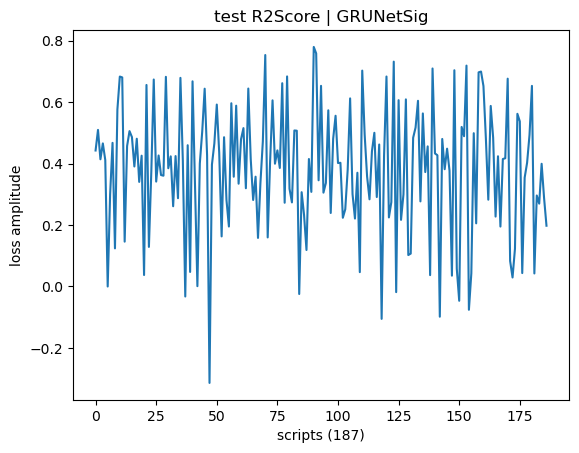

In [117]:
print(len(train_dataloader.dataset), len(test_dataloader.dataset))
import sys
torch.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize)
start_time = time.time()
criterion = R2Score().to(device)
predictions, loss = evaluate(criterion, seqModel, test_dataloader, loss_by_bs=False, use_pack=True, with_prob=True)
print("--- %s seconds ---" % (time.time() - start_time)) #0.5718670642756402


In [123]:
import sys
torch.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize)
def reconstruct_output(list_of_pred, batch_first, loss_list=None):
    inp_and_out = []
    if loss_list!=None:
        for p_list, loss_list in zip(list_of_pred, loss_list):
            inp, out, l = p_list
            out = torch.nn.utils.rnn.unpad_sequence(out, l, batch_first)
            if type(inp) is torch.nn.utils.rnn.PackedSequence:
                inp, _ = torch.nn.utils.rnn.pad_packed_sequence(inp)
            inp = torch.nn.utils.rnn.unpad_sequence(inp, l, batch_first)
            for i, o, lo in zip(inp, out, loss_list):
                inp_and_out.append((i, o, lo))
    else:
        for inp, out, l in list_of_pred:
            if type(inp) is torch.nn.utils.rnn.PackedSequence:
                inp, _ = torch.nn.utils.rnn.pad_packed_sequence(inp)
            print(l)
            out = torch.nn.utils.rnn.unpad_sequence(out, l, batch_first)
            inp = torch.nn.utils.rnn.unpad_sequence(inp, l, batch_first)
            for i, o in zip(inp, out):
                inp_and_out.append((i, o))
                print(i.shape, o.shape)
    return inp_and_out

def reconstruct_test_dataset(test_data):
    inp_and_out = []
    for batch in test_data:
        aus, bs, lengths = batch
        out = torch.nn.utils.rnn.unpad_sequence(bs, lengths, batch_first=False)
        inp = torch.nn.utils.rnn.unpad_sequence(aus, lengths, batch_first=False)
        for i, o in zip(inp, out):
            inp_and_out.append((i, o))
    return inp_and_out

dic = {}
dic = get_au_dictionary(dataset)
#inp_and_out = reconstruct_output(predictions, False)
inp_and_out = reconstruct_test_dataset(test_dataloader)

print(len(dic))

3750


In [ ]:
# torch.set_printoptions(precision=6)

# np.set_printoptions(threshold=sys.maxsize)
# for inp, pred in inp_and_out:
#     np_array = inp.cpu().data.numpy()
#     keys = [k for k, v in dic.items() if v.to_numpy().shape == np_array.shape and np.allclose(v.to_numpy(), np_array, atol=0.00001)]
#     print(keys)


In [9]:
import os

def save_results(dataframe, inp_and_out, dic, folder, bs_only=True):
    for au, pred in inp_and_out:
        au_np = au.cpu().data.numpy()
        keys = [k for k, v in dic.items() if v.to_numpy().shape == au_np.shape and np.allclose(v.to_numpy(), au_np, atol=0.00001)]
        columns = dataframe.columns[-61:]
        if bs_only:
            columns = columns[:-9] #remove 9 last columns
        df = pd.DataFrame(columns=columns, data=pred.cpu().data.numpy())
        path_to_folder = "predictions/" + folder
        if not os.path.exists(path_to_folder):
            os.makedirs(path_to_folder)
            print(path_to_folder)
        df.to_csv(path_to_folder +"_pred_"+keys[0]+'.csv', index=False)


def save_predictions_from_models(dataframe, voice_type):
    dic = get_au_dictionary(dataframe)
    models = [f.name for f in os.scandir("pytorch models/"+voice_type+'/')]
    class_of_models = [GRUNet, GRUNetNeg, GRUNetPack, GRUNetSig, FCNet]
    crits = [nn.L1Loss, nn.MSELoss, RMSELoss]
    for model_name in models:
        model_to_init = [m for m in class_of_models if m.__name__ == model_name.split('_')[0]]
        if not model_to_init: #if list is empty, skip iteration
            continue
        model_to_init = model_to_init[0]
        model = model_to_init(input_size, hidden_size, output_size).to(device)
        model.load_state_dict(torch.load(f"pytorch models/{voice_type}/{model_name}"))
        crit_to_init = [c for c in crits if c.__name__ == model_name.split('_')[1]][0]
        print(f"model: {model_to_init}\t crit: {crit_to_init}")
        criterion = crit_to_init().to(device)
        with_prob = False
        use_pack = False
        if model_to_init == GRUNetPack or model_to_init == GRUNetSeq or model_to_init == GRUNetAtt:
            with_prob = False
            use_pack = True
        elif model_to_init == GRUNetSig:
            with_prob = True
            use_pack = True
        else: #For FCNet, GRUNet, GRUNetNeg
            with_prob = False
            use_pack = False
        predictions, loss_list = evaluate(criterion, model, test_dataloader, False, use_pack=use_pack, with_prob=with_prob)
        inp_and_out = reconstruct_output(predictions, False)

        save_results(dataframe, inp_and_out, dic, f"{voice_type}/{model.__class__.__name__}_{criterion.__class__.__name__}_{voice_type}/")
        

def save_individual_csv_by_intensity_type(input_df, folder_path):
    columns = input_df.columns[-61:]
    groups = input_df.groupby('script_id').groups
    for script_id, idx in groups.items():
        full_df = input_df.iloc[idx]
        bs = full_df.iloc[:, -61:]
        df = pd.DataFrame(columns=columns, data=bs)
        full_path = os.path.join(data_path, "..", "individual_after_preprocessing", folder_path)
        full_path = os.path.normpath(full_path) #allows to use ".." in full path to go up one directory
        df.to_csv(full_path + '/' +  script_id + '.csv', index=False)



In [10]:
def training_and_test_models(voice_type):
    crits = [nn.L1Loss, nn.MSELoss, RMSELoss]
    models = [GRUNet, GRUNetNeg, GRUNetPack, GRUNetSig, FCNet]
    n_epochs=100
    print(f"for voice type: {voice_type}")
    for model_to_init in models:
        print(f"model {model_to_init}")
        for crit_to_init in crits:
            model = model_to_init(input_size, hidden_size, output_size).to(device)
            criterion = crit_to_init().to(device)
            print(criterion)
            model.apply(init_weights)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            start_time = time.time()
            model.train_(train_dataloader, valid_dataloader,n_epochs=n_epochs, criterion=criterion, optimizer=optimizer, voice_type=voice_type)
            print("--- %s seconds ---" % (time.time() - start_time))
            plt.savefig(f"loss/{model.__class__.__name__}_train_{criterion.__class__.__name__}_{voice_type}.png")
            plt.cla()
            plt.close()
            
            eval_crits = [crit_to_init, R2Score, nn.CosineSimilarity]
            best_model = model_to_init(input_size, hidden_size, output_size).to(device)
            best_model.load_state_dict(torch.load(f"pytorch models/{voice_type}/{model.__class__.__name__}_{criterion.__class__.__name__}_{voice_type}.pth"))
            for eval_crit in eval_crits:
                with_prob = False
                use_pack = False
                if eval_crit == nn.CosineSimilarity:
                    eval_criterion = eval_crit(dim=0).to(device)
                else:
                    eval_criterion = eval_crit().to(device)
                if model_to_init == GRUNetPack or model_to_init == GRUNetSeq or model_to_init == GRUNetAtt:
                    with_prob = False
                    use_pack = True
                elif model_to_init == GRUNetSig:
                    with_prob = True
                    use_pack = True
                else: #For FCNet, GRUNet, GRUNetNeg
                    with_prob = False
                    use_pack = False
                start_time = time.time()
                evaluate(eval_criterion, model, test_dataloader, False, use_pack=use_pack, with_prob=with_prob)
                print(f"evaluation time: {time.time() - start_time}")
                plt.savefig(f"loss/{model.__class__.__name__}_trained_with_{criterion.__class__.__name__}_test_{eval_criterion.__class__.__name__}_{voice_type}.png")
                plt.cla()
                plt.close()
                print("\n")
        print("\n\n")

def evaluate_saved_models(voice_type):
    models = [f.name for f in os.scandir("pytorch models/"+voice_type)]
    class_of_models = [GRUNetSeq]
    crits = [nn.L1Loss, nn.MSELoss, RMSELoss]
    for model_name in models:
        model_to_init = [m for m in class_of_models if m.__name__ == model_name.split('_')[0]]
        if not model_to_init:
            continue
        model_to_init = model_to_init[0]
        model = model_to_init(input_size, hidden_size, output_size).to(device)
        model.load_state_dict(torch.load(f"pytorch models/{voice_type}/{model_name}"))
        crit_to_init = [c for c in crits if c.__name__ == model_name.split('_')[1]][0]
        print(f"model: {model_to_init}\t crit: {crit_to_init}")
        eval_crits = [crit_to_init, R2Score, nn.CosineSimilarity]
        for eval_crit in eval_crits:
                with_prob = False
                use_pack = False
                if eval_crit == nn.CosineSimilarity:
                    eval_criterion = eval_crit(dim=0).to(device)
                else:
                    eval_criterion = eval_crit().to(device)
                if model_to_init == GRUNetPack or model_to_init == GRUNetSeq or model_to_init == GRUNetAtt:
                    with_prob = False
                    use_pack = True
                elif model_to_init == GRUNetSig:
                    with_prob = True
                    use_pack = True
                else: #For FCNet, GRUNet, GRUNetNeg
                    with_prob = False
                    use_pack = False
                start_time = time.time()
                evaluate(eval_criterion, model, test_dataloader, False, use_pack=use_pack, with_prob=with_prob)
                print(f"evaluation time: {time.time() - start_time}")
                print("\n")
                plt.savefig(f"loss/{model.__class__.__name__}_trained_with_{crit_to_init.__class__.__name__}_test_{eval_criterion.__class__.__name__}.png")
                plt.cla()
                plt.close()


In [11]:
session_info.show()

In [32]:
# path = "data/"
# dataset = pd.read_csv(path+"muffled_dataset.csv")

In [ ]:
# train_dataloader, valid_dataloader, test_dataloader = get_dataloader(batch_size=batch_size, data=dataset, short_sentences=False, only_bs=True)
# training_and_test_models("muffled")
# save_predictions_from_models(dataset, "muffled")

In [ ]:
# path = "data/"
# dataset = pd.read_csv(path+"normal_dataset.csv")

In [ ]:
# train_dataloader, valid_dataloader, test_dataloader = get_dataloader(batch_size=batch_size, data=dataset, short_sentences=False, only_bs=True)
# training_and_test_models("normal")
# save_predictions_from_models(dataset, "normal")

In [84]:
path = "data/"
dataset = pd.read_csv(path+"low_dataset.csv")


In [27]:
path = "data/"
dataset = pd.read_csv(path+"high_dataset.csv")

In [32]:

save_individual_csv_by_intensity_type(dataset, "all_high/")

data/


In [ ]:
train_dataloader, valid_dataloader, test_dataloader = get_dataloader(batch_size=batch_size, data=dataset, short_sentences=False, only_bs=True)
training_and_test_models("high")
save_predictions_from_models(dataset, "high")

In [ ]:
from pprint import pprint
from pathlib import Path
from collections import Counter
pd.set_option('display.max_colwidth', None)


def remove_unique_values(list_of_lists):
    flattened_list = [Path(item).name.split("/")[0] for sublist in list_of_lists for item in sublist]
    element_count = Counter(flattened_list)
    flattened_list_with_path = [item for sublist in list_of_lists for item in sublist]
    non_unique_elements = [element for element, count in element_count.items() if count > 1]
    modified_flattened_list = [element for element in flattened_list if element in non_unique_elements]
    modified_with_path = [item for item in flattened_list_with_path if Path(item).name.split("/")[0] in modified_flattened_list]
    list_of_scripts = []
    old_key = modified_with_path[0].rsplit('/', 2)[1].split('\\')[0]
    sublist =  []
    for i, item in enumerate(modified_with_path):
        key = item.rsplit('/', 2)[1].split('\\')[0]
        if key == old_key:
            sublist.append(item)
        else:
            list_of_scripts.append(list(sublist))
            sublist.clear()
            old_key = key
            sublist.append(item)
    list_of_scripts.append(list(sublist)) #append last sublist that was not added
    
    return list_of_scripts

def compare_predictions(bs_name):
    pred_folder = "predictions - Copy/"
    pred_folders = [[fil.path for fil in os.scandir(folder)] for folder in os.scandir(pred_folder) if folder.is_dir()]
    pred_folders = [[f for f in folder if not "RMSE" in f and not "L1" in f] for folder in pred_folders]
    pred_folders = [l for l in pred_folders if l] #Empty list are false
    removed_uniques = remove_unique_values(pred_folders)
    for num_scripts in range(0, len(removed_uniques[0])):
        #for ground truth bs
        script_n = Path(removed_uniques[0][num_scripts]).name
        script_n = script_n.split("_", 2)[2].split(".csv")[0]
        df_script = (dataset["script_id"] == script_n)
        jaw_open_bs = dataset[df_script][bs_name]
        fig = plt.figure(figsize=(15, 10))
        plt.plot(np.arange(0, jaw_open_bs.shape[0]), jaw_open_bs, color="black", label="gt")
        plt.xlabel("frames")
        plt.ylabel("amplitude")
        for num_folders in range(0, len(removed_uniques)):
                if num_folders == 0 or num_folders == 3 or num_folders == 6:
                    df_predictions = pd.read_csv(removed_uniques[num_folders][num_scripts])
                    jaw_open_bs_pred = df_predictions[bs_name]
                    model = removed_uniques[num_folders][num_scripts].rsplit('/', 2)[1].split('\\')[0]
                    model = model.split("_")[0]     
                    plt.plot(np.arange(jaw_open_bs.shape[0]),jaw_open_bs_pred, linestyle="dashdot", label=model)
                    plt.legend(loc="upper right")
                    plt.title("model predictions trained with MSE" + f"\n{bs_name}")
        display(fig)
        # plt.savefig("model comparison/model_comparison_" + script_n + ".png")
        # plt.cla()
        # plt.close()
        


compare_predictions("JawOpen")